# 1 Bayesian Optimization with Random Forest

## Optimizing a CNN with Scikit-Optimize
In this note, we will use Bayesian Operation to select the best hyperparameter 

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(42)



In [2]:
import itertools
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
from skopt import forest_minimize, gbrt_minimize
from skopt.space import Real,Categorical, Integer
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args


## Data preparation

## 2.1 Image re-scaling
We re-scale data for the CNN, between 0 and 1

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


In [8]:
X_train = X_train/255
X_test = X_test/255

## 2.2 Reshape
The images were stored in a pandas dataframe as 10d vectors of 784 vales. For a CNN with Keras, we need tensors with heigh x channel

Thus, we reshape all data to 28 x 28 x 1, 3-D matrices

The 3rd dimension corresponds to the channel. RGB imagens have 3 channels. Mnis images are in gray scale 2-D

In [9]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [10]:
## Target encoding
np.unique(y_train)




array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
# For keras, we need to create 10 dummy variables, one for each digiti

#Encode labels to one hot vectors( ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes= 10)
y_test = to_categorical(y_test, num_classes= 10)

y_train 

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

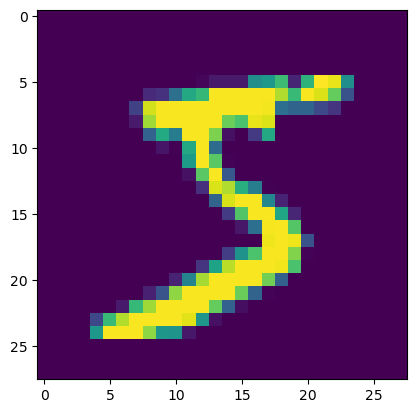

In [ ]:
# SOme image examples
g = plt.imshow(X_train[0][:,:,0])

## Define the CNN


In [13]:
from tensorflow.keras.layers import Flatten

#function to create the CNN
def create_cnn(
        # the hyperparamete to optimize are passed as argument
        learning_rate, # Learning rate for the optimizer
        num_conv_layers, # Number of conv layers
        num_dense_layers, # number of dense layers
        num_dense_nodes, # number of nodes in each dense layer
        activation # Activation function for all layers
):
    model = Sequential()
    
    #We add the different number of conv laers in the following loop
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same', activation=activation))

    model.add(MaxPool2D(pool_size=2, strides=2))

    #Second convolutional layer
    # Same hyperparameter to optimize as previous layer
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))
              
    #Flatten the output of the last conv layer to pass it to the dense layers
    model.add(Flatten())

    # We add the different number of dense layers in the following loop
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dense(10, activation='softmax'))
    
    optimizer = Adam(lr=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Define the hyperparameter space

- The number of fully-connected dense layers
- The number of nodes(neurons) for each of the dense layers
- Whether to use 'sigmoid' or 'relu' activation in all the layers

In [30]:
from skopt.utils import use_named_args


In [14]:
dim_learningrate = Real(
    low = 1e-6, high = 1e-2, prior='log-uniform', name =  'learning_rate',
) 
dim_num_conv_layers = Integer(low=1, high=3, name='num_conv_layers')
dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid'], name='activation')


In [15]:
#The hyperparameters space grid
param_grid = [dim_learningrate,
              dim_num_conv_layers,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

## Define the Objective Function

In [16]:
# We will save the model with this name
path_best_model = 'cnn_model.h5'

# Starting point for the optimization
best_accuracy = 0

In [25]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_conv_layers:', num_conv_layers)
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=learning_rate,
                       num_conv_layers=num_conv_layers,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [29]:
# Before we run the hyper-parameter optimization, 
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = [1e-5, 1, 1, 16, 'relu']

# Convert the list of default parameters to a dictionary
default_parameters_dict = {
	'learning_rate': default_parameters[0],
	'num_conv_layers': default_parameters[1],
	'num_dense_layers': default_parameters[2],
	'num_dense_nodes': default_parameters[3],
	'activation': default_parameters[4]
}

objective(default_parameters_dict)

TypeError: objective() got an unexpected keyword argument 'learning_rate'

In [32]:
# Remova o decorador para testar
def objective(learning_rate, num_conv_layers, num_dense_layers, num_dense_nodes, activation):
    print(f"learning_rate: {learning_rate}")
    print(f"num_conv_layers: {num_conv_layers}")
    print(f"num_dense_layers: {num_dense_layers}")
    print(f"num_dense_nodes: {num_dense_nodes}")
    print(f"activation: {activation}")

# Teste passando os parâmetros diretamente
objective(1e-5, 1, 1, 16, 'relu')


learning_rate: 1e-05
num_conv_layers: 1
num_dense_layers: 1
num_dense_nodes: 16
activation: relu


## 5.2 Bayesian optimization with random forests

In [23]:
#We could also approximate it with gradient boosting machines using gbrt_minimize

fm_ = forest_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0 = default_parameters, # the initial point
    acq_func = 'EI', # The acquisition function
    n_calls = 30, # the number of subsequent evaluations of f(x)
    random_state = 42,
)

learning_rate: 1.0e-05
num_conv_layers: 1
num_dense_layers: 1
num_dense_nodes: 16
activation: relu



ValueError: Argument(s) not recognized: {'lr': 1e-05}

## Analise results

In [ ]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % fm_.fun

In [ ]:
fm_.x

In [ ]:
fm_.space

In [ ]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_conv_laayers=%d
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" %(
    fm_.x[0], 
    fm_.x[1],
    fm_.x[2],
    fm_.x[3],
    fm_.x[4],
))

## Convergence  

In [ ]:
plot_convergence(fm_)

## Partially dependency plots

[plot_objective](https://scikit-optimize.readthedocs.io/en/latest/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective)


In [ ]:
dim_names = ['learning_rate', 'num_conv_layers', 'num_dense_layers', 'num_dense_nodes', 'activation']
plot_objective(result=fm_, plot_dims=dim_names)
plt.show()

# Evaluate the model

In [ ]:
# load best model

model = load_model(path_best_model)
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

## Confusion matrix

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

In [ ]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')